# AI Community @ Семинар № 8
## Поиск фигур на изображении

In [1]:
import cv2
import imutils
import numpy as np
import seaborn as sns
from collections import OrderedDict
from skimage.io import imshow
from scipy.spatial import distance as dist
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.grid'] = False

In [2]:
class ShapeDetector:
    """
    Class which detects shapes given contour.
    """
    
    def detect(self, c):
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        polygon = cv2.approxPolyDP(c, 0.04 * peri, True)
        if len(polygon) == 3:
            shape = "triangle"
        elif len(polygon) == 4:
            (x, y, w, h) = cv2.boundingRect(polygon)
            ar = w / float(h)
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        else:
            shape = "circle"
        return shape

OpenCV загружает изображения в формате BGR.  
Превратим BGR в RGB и уменьшим изображение:

In [3]:
image = cv2.imread("./images/shapes.jpg")[:, :, ::-1]
resized = imutils.resize(image, width=300)
resized_original = resized.copy()
resized_colors = resized.copy()
ratio = image.shape[0] / float(resized.shape[0])

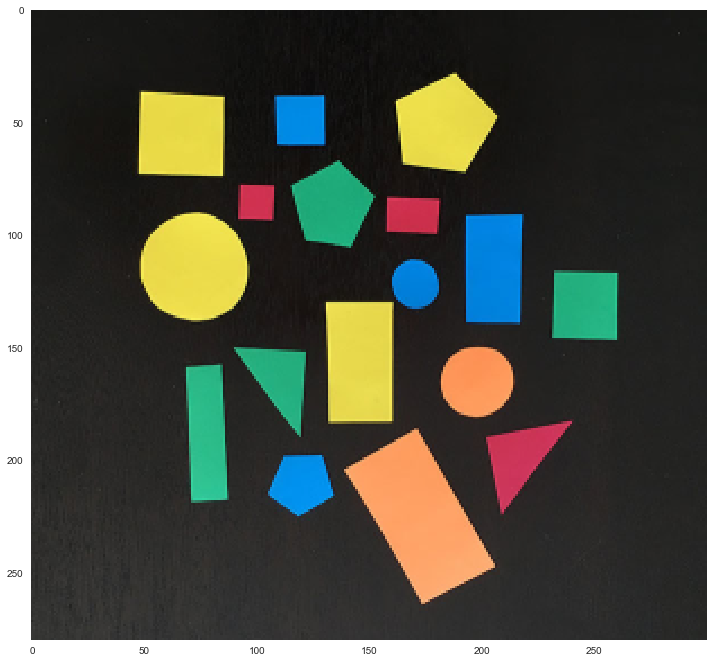

In [4]:
imshow(resized);

Для поиска контуров нужно бинаризованное изображение.  
Сначала переведем изображение в оттенки серого:

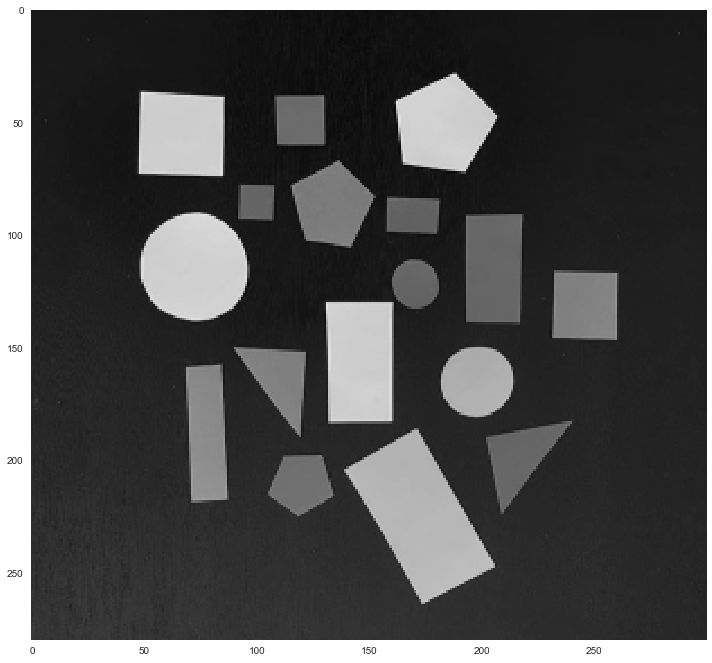

In [5]:
gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
imshow(gray);

Затем бинаризуем:

In [6]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

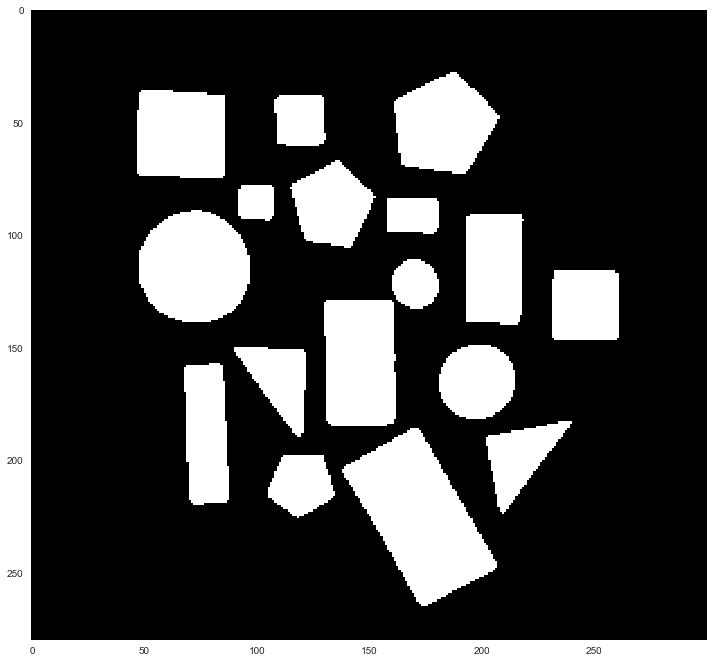

In [7]:
imshow(thresh)

Найдем контуры:

In [8]:
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if imutils.is_cv2() else contours[1]

Определим тип каждого объекта по его контуру.  
Для этого используем наш класс `ShapeDetector`:

In [9]:
sd = ShapeDetector()
for contour in contours:
    M = cv2.moments(contour)
    cX = int((M["m10"] / M["m00"]))
    cY = int((M["m01"] / M["m00"]))
    shape = sd.detect(contour)

    contour = contour.astype("int")
    cv2.drawContours(resized, [contour], -1, (0, 255, 0), 2)
    cv2.putText(resized, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

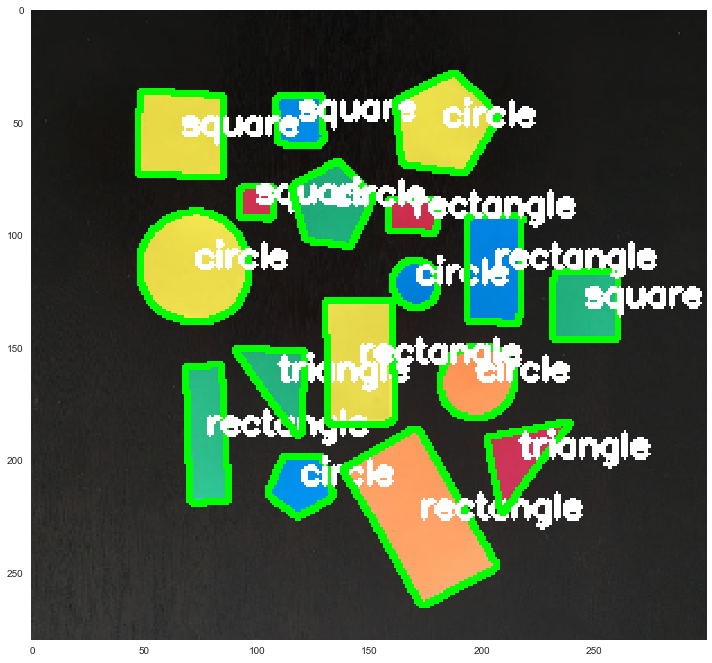

In [10]:
imshow(resized);

Попробуем определить цвет фигур

In [11]:
def get_color(image, contour):
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)
    mean = cv2.mean(image, mask=mask)[:3]
    
    colors = OrderedDict({
        "red": (255, 0, 0),
        "green": (0, 255, 0),
        "blue": (0, 0, 255)})
    lab = np.zeros((len(colors), 1, 3), dtype="uint8")
    for (i, (name, rgb)) in enumerate(colors.items()):
        lab[i] = rgb
    lab = cv2.cvtColor(lab, cv2.COLOR_RGB2LAB)
    current_color = (None, np.inf)
    color_indices = {0: 'red', 1: 'green', 2: 'blue'}
    for index, color in enumerate(lab):
        new_dist = dist.euclidean(color, mean)
        if new_dist < current_color[1]:
            current_color = (color_indices[index], new_dist)
    return current_color[0]

In [12]:
for contour in contours:
    M = cv2.moments(contour)
    cX = int((M["m10"] / M["m00"]))
    cY = int((M["m01"] / M["m00"]))
    shape = sd.detect(contour)

    contour = contour.astype("int")
    cv2.drawContours(resized, [contour], -1, (0, 255, 0), 2)
    color = get_color(cv2.cvtColor(resized_original, cv2.COLOR_RGB2LAB), contour)
    text = "{} {}".format(color, shape)
    cv2.putText(resized_colors, text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

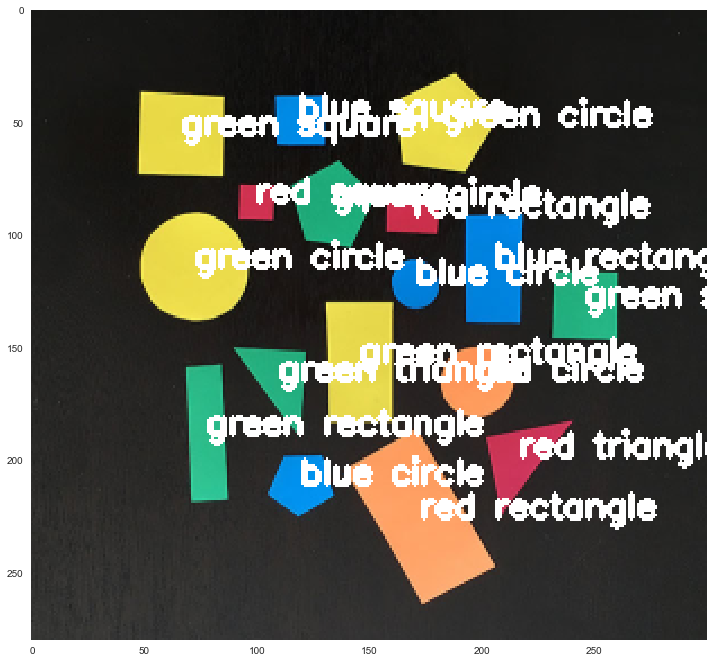

In [13]:
imshow(resized_colors); 